<h1 align="center">Identificação de Carácteres Utilizando Redes Neurais + TensorFlow</h1>

<img src="image/notmnist.png">
Neste exemplo, serão categorizadas imagens de letras. Os dados usados, <a href="http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html">notMNIST</a>, consistem de imagens de uma letra, do A até o J, em diferentes fontes. As imagens acima são alguns exemplos dos dados que serão usados para o treinamento da rede. alcançarem pelo menos 80% de precisão nos dados de teste.

In [8]:
import hashlib
import os
import pickle
from urllib.request import urlretrieve

import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from tqdm import tqdm
from zipfile import ZipFile
import tensorflow as tf

print('Todos os módulos importados')

Todos os módulos importados


O banco de dados notMNIST dataset é muito grande para computadores domésticos lidarem. Ele contem 500.000 imagens apenas para treinamento. Usaremos um subconjunto desde banco, com 15.000 imagens para cada letra (A-J).

In [2]:
def download(url, file):
    """
    Faz download do arquivo da <url>
    :param url: URL para o arquivo
    :param file: Path do arquivo local
    """
    if not os.path.isfile(file):
        print('Downloading ' + file + '...')
        urlretrieve(url, file)
        print('Download Completo')

# Download the training and test dataset.
download('https://s3.amazonaws.com/udacity-sdc/notMNIST_train.zip', 'notMNIST_train.zip')
download('https://s3.amazonaws.com/udacity-sdc/notMNIST_test.zip', 'notMNIST_test.zip')

# Make sure the files aren't corrupted
assert hashlib.md5(open('notMNIST_train.zip', 'rb').read()).hexdigest() == 'c8673b3f28f489e9cdf3a3d74e2ac8fa',\
        'notMNIST_train.zip está corrompido. Remova o arquivvo e tente novamente.'
assert hashlib.md5(open('notMNIST_test.zip', 'rb').read()).hexdigest() == '5d3c7e653e63471c88df796156a9dfa9',\
        'notMNIST_test.zip está corrompido. Remova o arquivvo e tente novamente.'

# Wait until you see that all files have been downloaded.
print('Download de todos os arquivos: Completo')

Download de todos os arquivos: Completo


In [3]:
def uncompress_features_labels(file):
    """
    Extrai features e labels do arquivo zip
    :param file: O arquivo zip do qual se extrairão os dados
    """
    features = []
    labels = []

    with ZipFile(file) as zipf:
        # Barra de Progresso
        filenames_pbar = tqdm(zipf.namelist(), unit='files')
        
        # Coleta features e labels de todos os arquivos
        for filename in filenames_pbar:
            # Checa se o arquivo é um diretório
            if not filename.endswith('/'):
                with zipf.open(filename) as image_file:
                    image = Image.open(image_file)
                    image.load()
                    # Carrega os dados da imagem como um vetor unidimensional
                    # Usando float32 para salvar espaço na memória
                    feature = np.array(image, dtype=np.float32).flatten()

                # Carrega a letra no nome do arquivo. Essa é a letra da imagem
                label = os.path.split(filename)[1][0]

                features.append(feature)
                labels.append(label)
    return np.array(features), np.array(labels)

# Coleta features e labels dos arquivos zip
train_features, train_labels = uncompress_features_labels('notMNIST_train.zip')
test_features, test_labels = uncompress_features_labels('notMNIST_test.zip')

# Limita o montante de dados para trabalhar com um docker container
docker_size_limit = 150000
train_features, train_labels = resample(train_features, train_labels, n_samples=docker_size_limit)

# Seta flags para feature engineering
is_features_normal = False
is_labels_encod = False

# Aguarda até que todas as features e labels tenham sido extraídas.
print('Todas as features e labels extraídas.')

100%|██████████| 10001/10001 [00:01<00:00, 5942.36files/s]


Todas as features e labels extraídas.


<img src="image/Mean_Variance_Image.png" style="height: 75%;width: 75%; position: relative; right: 5%">

Escalonamento Min-Max:

$
X'=a+{\frac {\left(X-X_{\min }\right)\left(b-a\right)}{X_{\max }-X_{\min }}}
$

In [4]:
def normalize_grayscale(image_data):
    """
    Normaliza os dados de imagem com escalonamento Min-Max para o intervalo [0.1, 0.9]
    :param image_data: Os dados de imagem a serem normalizados
    :return: Dados da imagem normalizados
    """
    n_max = 0.9
    n_min = 0.1
    x = image_data
    
    return (x - x.min()) / (x.max() - x.min()) * (n_max - n_min) + n_min


# Test Cases
np.testing.assert_array_almost_equal(
    normalize_grayscale(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 255])),
    [0.1, 0.103137254902, 0.106274509804, 0.109411764706, 0.112549019608, 0.11568627451, 0.118823529412, 0.121960784314,
     0.125098039216, 0.128235294118, 0.13137254902, 0.9],
    decimal=3)
np.testing.assert_array_almost_equal(
    normalize_grayscale(np.array([0, 1, 10, 20, 30, 40, 233, 244, 254,255])),
    [0.1, 0.103137254902, 0.13137254902, 0.162745098039, 0.194117647059, 0.225490196078, 0.830980392157, 0.865490196078,
     0.896862745098, 0.9])

if not is_features_normal:
    train_features = normalize_grayscale(train_features)
    test_features = normalize_grayscale(test_features)
    is_features_normal = True

print('Testes Passaram!')

Testes Passaram!


In [5]:
if not is_labels_encod:
    # Transforma labels em números aplicando One-Hot Encoding
    encoder = LabelBinarizer()
    encoder.fit(train_labels)
    train_labels = encoder.transform(train_labels)
    test_labels = encoder.transform(test_labels)

    # Converte para float32, para serem multiplicados pelas features no TensorFlow
    train_labels = train_labels.astype(np.float32)
    test_labels = test_labels.astype(np.float32)
    is_labels_encod = True

print('Labels Transformadas com One-Hot Encodeding')

Labels Transformadas com One-Hot Encodeding


In [6]:
assert is_features_normal
assert is_labels_encod

# Divide os dados aleatoriamente para treino e validação
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.05,
    random_state=832289)

print('Features e labels de treinamento ramdomizadas e divididas.')

Features e labels de treinamento ramdomizadas e divididas.


In [12]:
# Save the data for easy access
pickle_file = 'notMNIST.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open('notMNIST.pickle', 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': train_features,
                    'train_labels': train_labels,
                    'valid_dataset': valid_features,
                    'valid_labels': valid_labels,
                    'test_dataset': test_features,
                    'test_labels': test_labels,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Dados salvos em arquivo pickle.')

Dados salvos em arquivo pickle.


## Checkpoint

In [12]:
%matplotlib inline

# Carrega os módulos
import pickle
import math

import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc

# Recarrega os dados
pickle_file = 'notMNIST.pickle'
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  train_features = pickle_data['train_dataset']
  train_labels = pickle_data['train_labels']
  valid_features = pickle_data['valid_dataset']
  valid_labels = pickle_data['valid_labels']
  test_features = pickle_data['test_dataset']
  test_labels = pickle_data['test_labels']
  del pickle_data; gc()  # Libera memória

print('Dados e módulos carregados.')

EOFError: Ran out of input

<img src="image/network_diagram.png" style="height: 40%;width: 40%; position: relative; right: 10%">

In [9]:
# All the pixels in the image (28 * 28 = 784)
features_count = 784
# All the labels (A to J)
labels_count = 10

# Set the features and labels tensors
features = tf.placeholder(tf.float32)
labels = tf.placeholder(tf.float32)

# Set the weights and biases tensors
weights = tf.Variable(tf.truncated_normal((features_count, labels_count)))
biases = tf.Variable(tf.zeros((labels_count)))

# Feed dicts for training, validation, and test session
train_feed_dict = {features: train_features, labels: train_labels}
valid_feed_dict = {features: valid_features, labels: valid_labels}
test_feed_dict = {features: test_features, labels: test_labels}

# Linear Function WX + b
logits = tf.matmul(features, weights) + biases

prediction = tf.nn.softmax(logits)

# Cross entropy
cross_entropy = -tf.reduce_sum(labels * tf.log(prediction), reduction_indices=1)

# Training loss
loss = tf.reduce_mean(cross_entropy)

# Create an operation that initializes all variables
init = tf.global_variables_initializer()

# Test Cases
with tf.Session() as session:
    session.run(init)
    session.run(loss, feed_dict=train_feed_dict)
    session.run(loss, feed_dict=valid_feed_dict)
    session.run(loss, feed_dict=test_feed_dict)
    biases_data = session.run(biases)

assert not np.count_nonzero(biases_data)

print('Testes passaram!')

Testes passaram!


In [10]:
# Determine if the predictions are correct
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
# Calculate the accuracy of the predictions
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

print('Accuracy function created.')

Accuracy function created.


<img src="image/Learn_Rate_Tune_Image.png" style="height: 70%;width: 70%">

Epoch  5/5: 100%|██████████| 1114/1114 [00:06<00:00, 162.33batches/s]


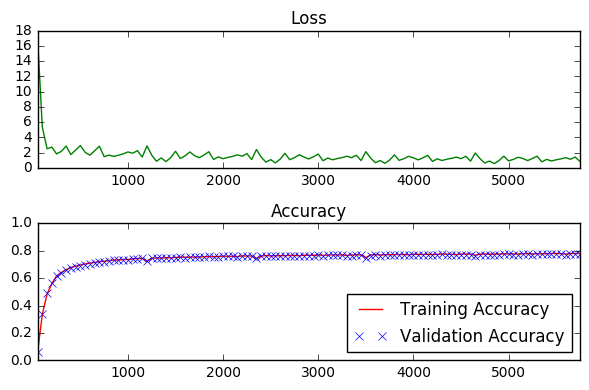

Validation accuracy at 0.7688000202178955


In [28]:
# Change if you have memory restrictions
batch_size = 128

epochs = 5
learning_rate = 0.1

# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)    

# The accuracy measured against the validation set
validation_accuracy = 0.0

# Measurements use for graphing loss and accuracy
log_batch_step = 50
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

with tf.Session() as session:
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer and get loss
            _, l = session.run(
                [optimizer, loss],
                feed_dict={features: batch_features, labels: batch_labels})

            # Log every 50 batches
            if not batch_i % log_batch_step:
                # Calculate Training and Validation accuracy
                training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
                validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)

        # Check accuracy against Validation data
        validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'x', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

print('Validation accuracy at {}'.format(validation_accuracy))

In [30]:
# The accuracy measured against the test set
test_accuracy = 0.0

with tf.Session() as session:
    
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer
            _ = session.run(optimizer, feed_dict={features: batch_features, labels: batch_labels})

        # Check accuracy against Test data
        test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)


assert test_accuracy >= 0.80, 'Test accuracy at {}, should be equal to or greater than 0.80'.format(test_accuracy)
print('Test Accuracy is {}'.format(test_accuracy))

Epoch  5/5: 100%|██████████| 1114/1114 [00:01<00:00, 885.16batches/s]

Test Accuracy is 0.8445000052452087
